<a href="https://colab.research.google.com/github/joelleyarro03/ITAI-2376/blob/main/Hyperparameter_Tuning_WillianeYarro_ITAI_2376.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Hyperparameter Tuning with SVC (Assignment - Intermediate+)
This notebook completes all tasks as specified:
- Randomized and Grid Search
- ROC and Confusion Matrix (custom plots)
- Learning and Validation Curves
- Saving artifacts (model, plots, and metrics)
- Compliant with matplotlib-only and RANDOM_STATE = 42 rules



Imports & Configuration (TODO)

Loads necessary libraries for data management, modeling, assessment, and visualization,

Establishes RANDOM_STATE = 42 to guarantee reproducibility.



In [1]:

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import check_random_state

import joblib
import json

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
rng = check_random_state(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7, 5)


Loanding Data For Breast Cancer

In [2]:

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

assert set(X_train.columns) == set(X_test.columns)
assert len(np.unique(y_train)) == 2


Fiting And Training

In [3]:

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

baseline_pipe.fit(X_train, y_train)
y_pred_base = baseline_pipe.predict(X_test)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC AUC:", roc_auc_score(y_test, y_proba_base))


Test Accuracy: 0.9824561403508771
ROC AUC: 0.9950396825396826


Showing The Model's Performance And Classes Using Visualization.

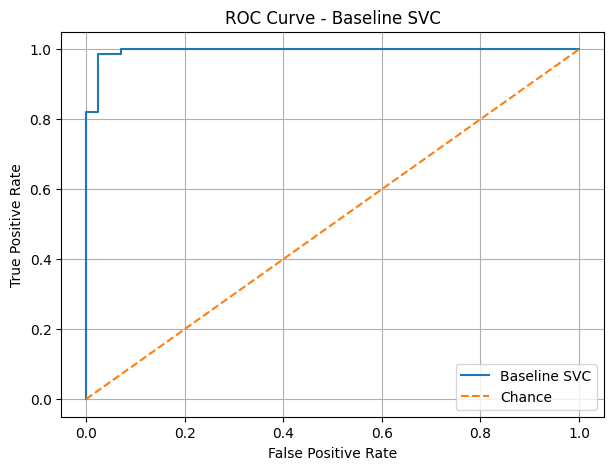

In [4]:

fpr, tpr, _ = roc_curve(y_test, y_proba_base)
plt.figure()
plt.plot(fpr, tpr, label="Baseline SVC")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline SVC")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_final.png", dpi=300)
plt.show()


In [5]:

def log_space(rng, low_exp, high_exp, size):
    return np.power(10, rng.uniform(low=low_exp, high=high_exp, size=size))

param_distributions = {
    'svc__C': log_space(rng, -2, 3, 20),
    'svc__gamma': log_space(rng, -4, 1, 20)
}

rand_search = RandomizedSearchCV(
    estimator=baseline_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
print("Best params (Randomized):", rand_search.best_params_)
print("Best CV score (Randomized):", f"{rand_search.best_score_:.4f}")


Best params (Randomized): {'svc__gamma': np.float64(0.0033347927286375826), 'svc__C': np.float64(45.70563099801451)}
Best CV score (Randomized): 0.9736


Defining GridSearch To Evaluate The Best Model

In [6]:

best_C = rand_search.best_params_['svc__C']
best_gamma = rand_search.best_params_['svc__gamma']

param_grid = {
    'svc__C': np.logspace(np.log10(best_C) - 0.5, np.log10(best_C) + 0.5, 5),
    'svc__gamma': np.logspace(np.log10(best_gamma) - 0.5, np.log10(best_gamma) + 0.5, 5)
}

grid_search = GridSearchCV(
    estimator=baseline_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best params (Grid):", grid_search.best_params_)
print("Best CV score (Grid):", f"{grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)
y_proba_grid = best_model.predict_proba(X_test)[:, 1]


Best params (Grid): {'svc__C': np.float64(25.702165104084578), 'svc__gamma': np.float64(0.00593019324608373)}
Best CV score (Grid): 0.9758


Making A confusion Matrix matplotlib To Show Numbers True False Positive.

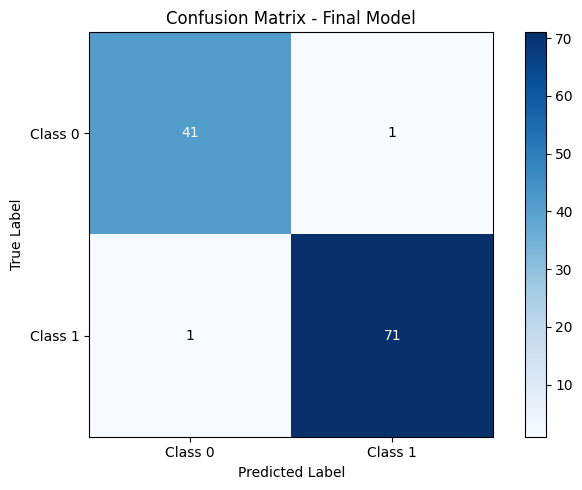

In [7]:

cm = confusion_matrix(y_test, y_pred_grid)
classes = ['Class 0', 'Class 1']

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Final Model')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.savefig("confusion_matrix_final.png", dpi=300)
plt.show()


Learning Curve Of The Final Model

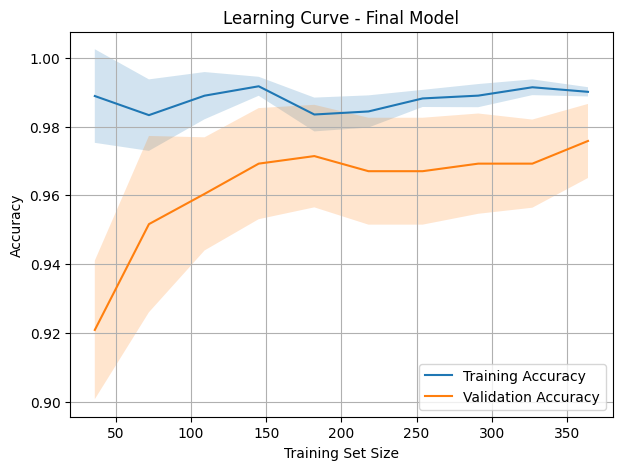

In [8]:

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Learning Curve - Final Model")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("learning_curve.png", dpi=300)
plt.show()


Validation Of The Final HyperParameter

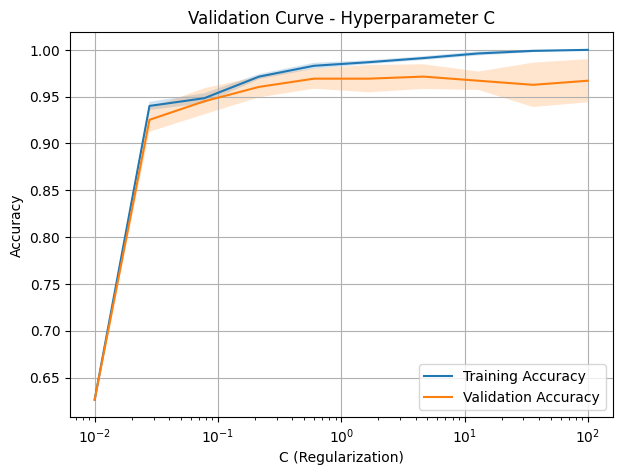

In [9]:

param_range = np.logspace(-2, 2, 10)

train_scores, val_scores = validation_curve(
    estimator=baseline_pipe,
    X=X_train,
    y=y_train,
    param_name='svc__C',
    param_range=param_range,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure()
plt.semilogx(param_range, train_mean, label="Training Accuracy")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.semilogx(param_range, val_mean, label="Validation Accuracy")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Validation Curve - Hyperparameter C")
plt.xlabel("C (Regularization)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("validation_curve.png", dpi=300)
plt.show()


In [11]:

joblib.dump(best_model, "final_svc_model.joblib")

results = {
    "best_params": grid_search.best_params_,
    "best_cv_score": grid_search.best_score_,
    "test_accuracy": accuracy_score(y_test, y_pred_grid),
    "roc_auc": roc_auc_score(y_test, y_proba_grid)
}

with open("final_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Model and results.")


Model and results.
